In [1]:
import scanpy as sc

# Read the h5ad file created from Seurat
protein_data = sc.read_h5ad("data/processed/BM-CITE_ADT.h5ad")
rna_data = sc.read_h5ad("data/processed/BM-CITE_RNA.h5ad")

print(protein_data)
print(rna_data)

AnnData object with n_obs × n_vars = 30672 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lane', 'donor', 'celltype', 'nCount_ADT', 'nFeature_ADT'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_apca'
    varm: 'APCA'
AnnData object with n_obs × n_vars = 30672 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lane', 'donor', 'celltype', 'nCount_ADT', 'nFeature_ADT'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca'
    varm: 'PCs'


C:\Users\wzy66\anaconda3\envs\MultiOmicsIntegration\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


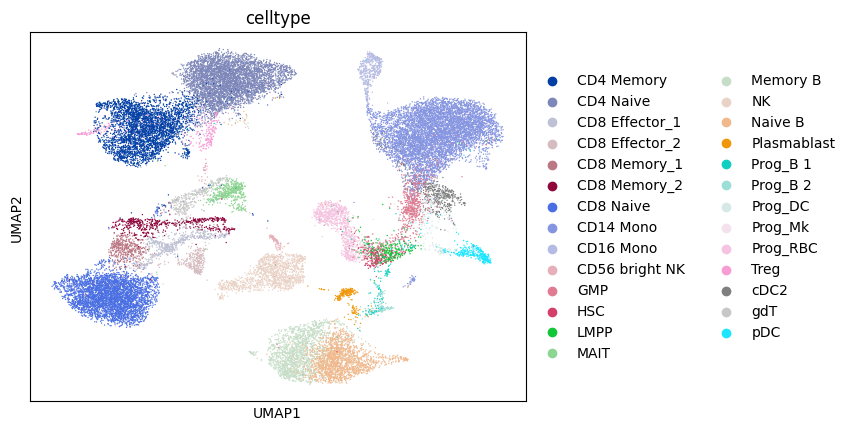

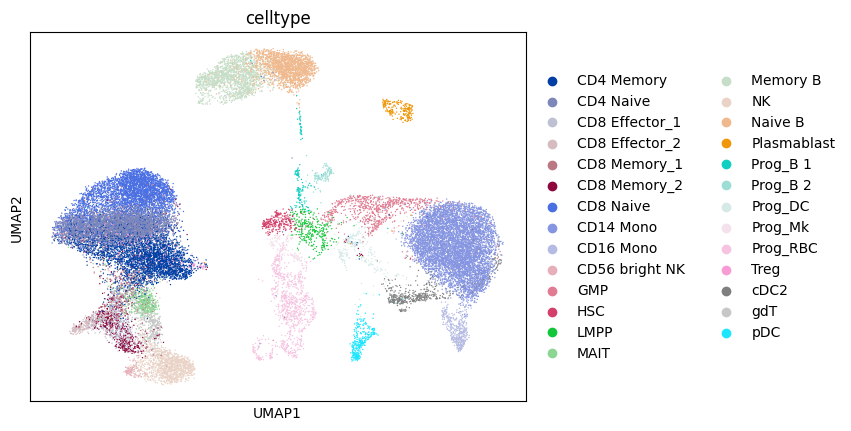

In [2]:
def UMAP_plot(adata, use_rep='X_pca'):
    # Compute the neighborhood graph using the PCA representation
    sc.pp.neighbors(adata, use_rep=use_rep)

    # Compute UMAP
    sc.tl.umap(adata)

    # Plot UMAP colored by a metadata column (e.g., celltype)
    sc.pl.umap(adata, color='celltype')

UMAP_plot(protein_data, use_rep='X_apca')
UMAP_plot(rna_data)